<br><h1 style="font-family:times new roman"><center>Fall Detection NN Model</center></h1>
<h3 style="font-weight:normal;font-family:times new roman"><center> <em>Redback Operations</em> </center> </h3> 
<h4 style="font-weight:normal;font-family:times new roman"> <center><em>Elderly Wearable Tech <br> <br> Manan Gangar | mgangar@deakin.edu.au <br></em> </center></h4>

## Importing Libraries

The subsequent libraries are imported to facilitate working with the dataset, splitting the data, visualizing patterns, creating models, and calculating metrics.

In [1]:
# Used to work with dataframe
import pandas as pd  
import numpy as np 

# Used to visualise activity and falling data
import matplotlib.pyplot as plt

# Used to split data to train and test
from sklearn.model_selection import train_test_split

# Used to create model
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# Used to check model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Loading Data

The data, stored in the `/data` folder, is loaded into the `data` variable using pandas.

In [2]:
data = pd.read_csv("data/acc_gyr.csv")
# Reading the csv file

# Displaying top columns of dataset
display(data.head())

# Displaying the unique labels in the dataset
print(f'Unqiue label values – {data.label.unique()}')

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall


Unqiue label values – ['fall' 'rfall' 'lfall' 'light' 'sit' 'walk' 'step']


## Preprocess the Data

The dataset contains multiple labels for specific types of falls and activities. However, for the model, only general labels, namely `fall` and `activity`, are necessary. Therefore, the specific labels are replaced with the general ones. Furthermore, since the data is imbalanced, certain rows from one of the labels are removed to balance the dataset. Additionally, the data is encoded into categorical variables.

In [3]:
# Replacing the current values to get just two labels – Fall (contains all fall labels) and Activity (contains all activity label)
data['label'] = data['label'].map({"fall": 1, "rfall": 1, "lfall": 1, "light": 1, "sit": 0, "walk": 0, "step": 0})

# Printing the number of values in each label to check for imbalance
print(f'Label value counts –\n{data.label.value_counts()}\n')

# Removing data from categories that has higher value counts
data.drop(data[data["label"] == 1].head(55600-41200).index, inplace=True)
data.reset_index(drop=True, inplace=True)

# Getting the new count
print(f'Label value counts –\n{data.label.value_counts()}')

Label value counts –
label
1    55600
0    41200
Name: count, dtype: int64

Label value counts –
label
1    41200
0    41200
Name: count, dtype: int64


## Splitting Data

Following data processing, it is divided into X and y sets. Moreover, each individual instance of activity or fall is segregated into distinct lists. Given that the original data was recorded at 20Hz for 20 seconds, the data is divided at every 400 readings. Ultimately, the data is partitioned into training and testing sets based on a 75% and 25% split, respectively.

In [4]:
# Getting the X and y data
data_X = data.loc[:, data.columns != 'label']
data_y = data.loc[:, 'label']

# Separating each instances so each index contains a single fall/activity instance. The data was read at 40hz for 20secs. i.e., 400 readings
X = np.array(np.array_split(data_X, len(data)/400))
y = np.array([labels.iloc[0] for labels in np.array_split(data_y, len(data_y)/400)])

# Splitting the data to train and †est data – 0.75 and 0.25 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48)

/opt/anaconda3/envs/tf_fall/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/envs/tf_fall/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


## Visualize Data

In order to visualize the data for patterns and model metrics during training, a function is created. This function accepts data along with specific parameters and plots the data for visualization.

In [5]:
# Function to help plot the data
def plot_data(data, indexes, labels, title, xlabel, ylabel, subplot, range_x=np.linspace(0, 20, 400)):
    
    # Creating a Figure
    plt.figure(1, figsize=(18,4))

    # Creating subplots
    ax = plt.subplot(1,2,subplot)
    
    # Adding lines for each axis
    for i in range(len(indexes)):
        plt.plot(range_x,data[:,indexes[i]], label=labels[i])

    # Adding the labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.legend()

The function created is utilized initially to examine the accelerometer and gyroscope readings for a "fall" instance. Subsequently, the accelerometer and gyroscope readings for an "activity" instance are plotted.

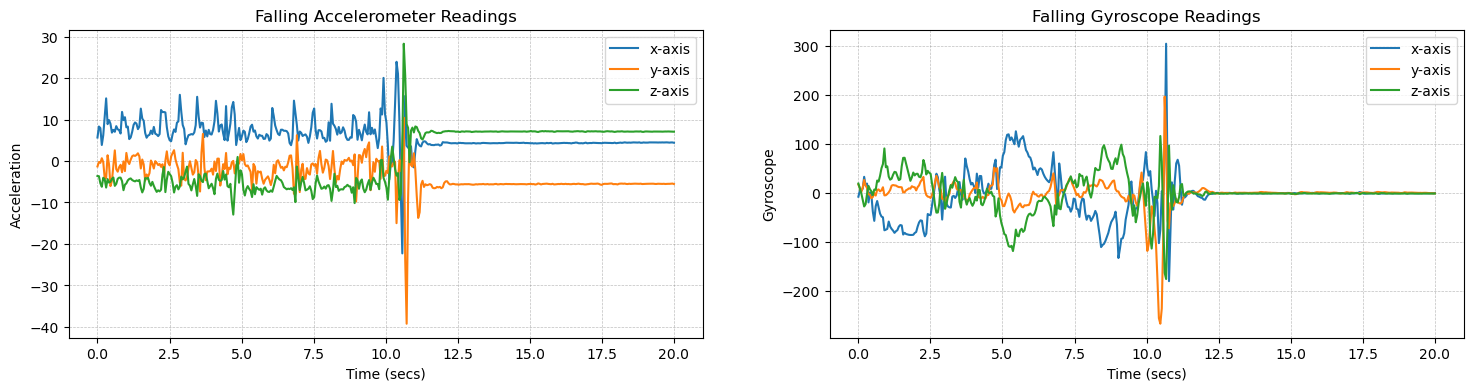

In [6]:
# Plotting the accelerometer and gyroscope data for Falling instance
plot_data(X[np.where(y==1)[0][0]], [0,1,2], ['x-axis','y-axis','z-axis'], 'Falling Accelerometer Readings', 'Time (secs)', 'Acceleration', 1)
plot_data(X[np.where(y==1)[0][0]], [3,4,5], ['x-axis','y-axis','z-axis'], 'Falling Gyroscope Readings', 'Time (secs)', 'Gyroscope', 2)

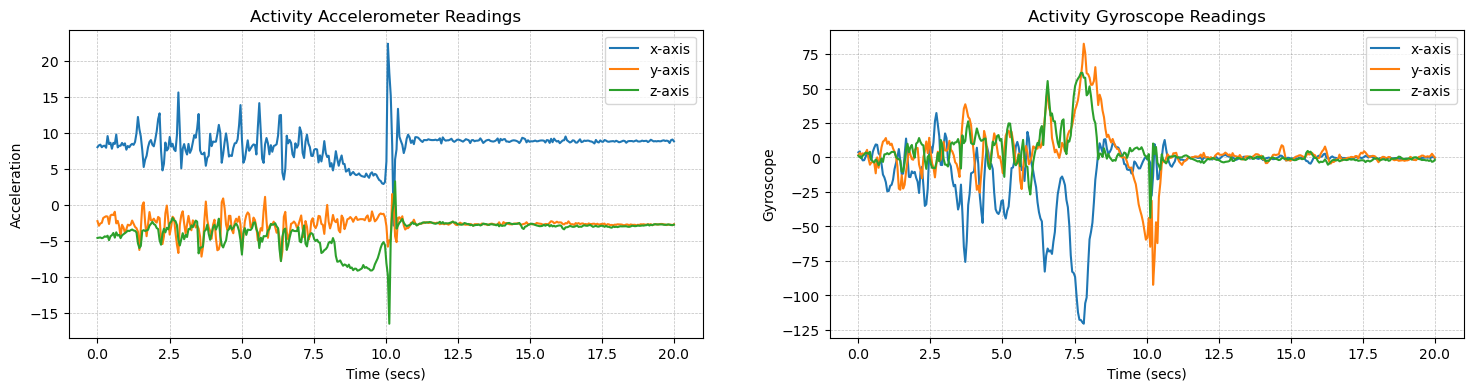

In [7]:
# Plotting the accelerometer and gyroscope data for Activity instance
plot_data(X[np.where(y==0)[0][0]], [0,1,2], ['x-axis','y-axis','z-axis'], 'Activity Accelerometer Readings', 'Time (secs)', 'Acceleration', 1)
plot_data(X[np.where(y==0)[0][0]], [3,4,5], ['x-axis','y-axis','z-axis'], 'Activity Gyroscope Readings', 'Time (secs)', 'Gyroscope', 2)

The visualisations facilitate the examination of differences in readings when an elder experiences a fall versus when they are performing an activity. In the case of a fall instance, there is a sudden change in readings that persists for approximately 1.5 seconds, followed by a near-flat line indicating immobility. Conversely, in the activity instance, there is no abrupt change observed, and beyond a certain point, the readings exhibit continuous fluctuations, indicating more movement compared to a fall instance.

## Model Creation

The model is constructed based on research findings [1], which employ 3 convolutional layers and 3 pooling layers. The ensuing model architecture is as follows:

In [8]:
# Creating a Sequential model
model = Sequential(
    [
        # Input Layer
        InputLayer(shape=X_train[0].shape),

        # Conv1D layer followed by max pooling
        Conv1D(32, 2, activation = 'relu', padding='same'),
        MaxPooling1D(pool_size=2, strides=2, padding='valid'),
        
        Conv1D(64, 2, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2, strides=2, padding='valid'),

        # Conv1D layer with dropout and max pooling
        Conv1D(128, 2, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.1)),
        Dropout(0.5),
        MaxPooling1D(pool_size=2, strides=2, padding='valid'),

        # Flattening the output
        Flatten(),

        # Dense layer with dropout
        Dense(64, activation = 'sigmoid', kernel_regularizer=keras.regularizers.l2(l2=0.1)),
        Dropout(0.5),

        # Output layer
        Dense(1, activation='sigmoid')
    ]
)

model.summary()

2024-05-10 16:47:07.204941: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-10 16:47:07.204962: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-10 16:47:07.204976: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-10 16:47:07.204994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-10 16:47:07.205005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 400, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,817 (1.64 MB)

 Trainable params: 430,817 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

After creation, the model is compiled with the following settings:
- Optimizer: Adam
- Loss function: Binary Crossentropy
- Metrics: Accuracy

Moreover, a callbacks list is generated to enable early stopping, configured with the following settings:
- Metric to be monitored: Accuracy
- Patience: 5
- Restore best weights: True
- Starting epoch: 7

Subsequently, the model is trained for `50 epochs` and saved in the `/Models` folder.

In [9]:
# Compiling the model
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])

# Setting the callbacks for early stopping
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="acc",  # Checking accuracy to decide early stopping
        patience=5,  # Wait for 5 epochs before stopping
        restore_best_weights=True,  # Restoring the weights with best accuracy
        start_from_epoch=7)  # Start after 7 epochs
    ]

# Fit the model
history = model.fit(X_train, y_train, epochs = 50, validation_data= (X_test, y_test), callbacks=callbacks)

# Saving the model
model.save('models/fall_detection_model.keras')

Epoch 1/50


2024-05-10 16:47:07.786266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - acc: 0.4263 - loss: 21.1282 - val_acc: 0.4231 - val_loss: 17.7127
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.5520 - loss: 16.9042 - val_acc: 0.6346 - val_loss: 14.1476
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.5416 - loss: 13.6341 - val_acc: 0.7885 - val_loss: 11.4383
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.5677 - loss: 11.0001 - val_acc: 0.4808 - val_loss: 9.4282
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.6673 - loss: 9.0071 - val_acc: 0.8654 - val_loss: 7.8103
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.7298 - loss: 7.5901 - val_acc: 0.8462 - val_loss: 6.6427
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.7615 - loss: 6.4296 - val_acc: 0.8462 - val_loss: 5.7125
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.8595 - loss: 5.4672 - val_acc: 0.9423 - val_loss: 4.8305
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.9276 - loss: 4.6689 - val

## Visualize Training Metrics

Following the model training, the loss and accuracy for both training and validation sets are visualized across epochs. These visualizations indicate a degree of overfitting still present in the model. Possible causes of overfitting include:

- Insufficient regularization: Despite the model employing regularization techniques like L2 regularization and dropouts, further hyperparameter tuning for these methods may mitigate overfitting.
- Limited data: Currently, the training set comprises only 154 instances in total. Consequently, it's plausible that the model architecture is relatively complex and readily memorizes the data.

To mitigate overfitting, one could undertake further hyperparameter tuning or collect more data to enhance model performance.


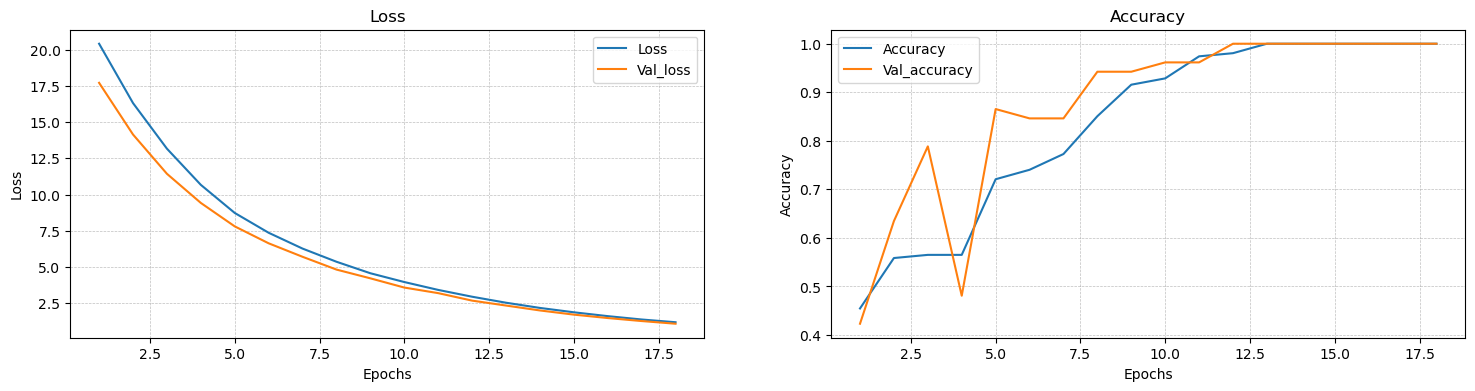

In [10]:
# Getting the loss and accuracy data for epochs
loss_data = np.array(pd.DataFrame({'loss': history.history['loss'], 'val_loss':history.history['val_loss']}))
acc_data = np.array(pd.DataFrame({'acc': history.history['acc'], 'val_acc':history.history['val_acc']}))

# Getting the range for x axis
x = range(1, len(history.history['loss']) + 1)

# Plotting the loss and accuracy data
plot_data(loss_data, [0,1], ['Loss','Val_loss'], 'Loss', 'Epochs', 'Loss', 1, x)
plot_data(acc_data, [0,1], ['Accuracy','Val_accuracy'], 'Accuracy', 'Epochs', 'Accuracy', 2, x)

## Test Data Metrics

Ultimately, the model is employed to predict the test data and evaluate its performance on unseen data. The metrics reveal that the model effectively learns the training data and achieves optimal performance metrics on the test data.

In [11]:
# Predicting the test dataset
y_pred = (model.predict(X_test) > 0.5).astype("int")

# Getting the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the model metrics on test data
print("---Model Metrics---")
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
---Model Metrics---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Conclusion

The primary objective of the file is to develop a Neural Network model for fall detection, as part of the elderly wearable technology project at Redback Operations company. While the model demonstrates commendable metrics, it exhibits overfitting as discussed earlier. The future course of action involves acquiring a larger dataset, retraining the model, and conducting hyperparameter tuning to attain optimal performance in fall detection.

## Assumptions

The fall detection feature operates under the following assumptions:
- The age of participants from whom the data was collected is not specified. Therefore, the first assumption is that the data is applicable for detecting falls in the elderly.
- The data was collected from participants with heights ranging between 175cm and 198cm. The second assumption is that the model can generalize to detect falls in elderly individuals outside this height range.
- The sensors were positioned around the chest of the participants during data collection. Consequently, the third assumption is that the model can generalize to readings taken with the sensor positioned around the wrist of the elderly.


<H2>References</H2>

1. Y. Chen and Y. Xue, "A Deep Learning Approach to Human Activity Recognition Based on Single Accelerometer," 2015 IEEE International Conference on Systems, Man, and Cybernetics, Hong Kong, China, 2015, pp. 1488-1492, doi: 10.1109/SMC.2015.263.
2. Santos, G. L., Endo, P. T., Monteiro, K. H. C., Rocha, E. D. S., Silva, I., & Lynn, T. (2019). Accelerometer-Based Human Fall Detection Using Convolutional Neural Networks. Sensors (Basel, Switzerland), 19(7), 1644. https://doi.org/10.3390/s19071644
3. Falls vs Normal Activities. (n.d.). Www.kaggle.com. Retrieved May 10, 2024, from https://www.kaggle.com/datasets/enricogrimaldi/falls-vs-normal-activities